# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/supannee/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
# 1. To train the model on our dataset, we need to subclass Config and Dataset, 
#    and modify the attributes we need to change.
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # RPN is Region Proposal Network and anchors are the regions (grids) 
    #   that the RPN scans over. Anchors have different sizes and aspect ratios and 
    #   they overlap to cover as much of the image as possible.
    # Use smaller anchors because our image and objects are small
    # type(RPN_ANCHOR_SCALES) = tuple
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000
ROI_

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [51]:
# Test code
bg_color = np.array([random.randint(0, 255) for _ in range(3)])
print(bg_color)
print(bg_color.shape)
print(type(bg_color))

N = random.randint(1, 4)
print('N:',N)

shape = random.choice(["square", "circle", "triangle"])
print(shape)
print(type(shape))
# Get centre x, y and size
height = 128
width = 128
buffer = 20
y = random.randint(buffer, height - buffer - 1)
x = random.randint(buffer, width - buffer - 1)
s = random.randint(buffer, height//4)
c = (x,y,s)
print(c)
print(type(c))
###
num = []
num.append(('square',(0,0,0)))
num.append(('circle',(1,0,0)))
print(num)
print(len(num))
####
print('c:',c)
_x,_y,_s = c
print(_x)
print(_y)
print(_s)

[153 181  29]
(3,)
<class 'numpy.ndarray'>
N: 2
square
<class 'str'>
(62, 45, 32)
<class 'tuple'>
[('square', (0, 0, 0)), ('circle', (1, 0, 0))]
2
c: (62, 45, 32)
62
45
32


In [58]:
boxes = []
boxes.append([1,2,3,4])
boxes.append([5,6,7,8])
print(boxes)
print(type(boxes))
print(type(num))
print('a1:', np.arange(1))
print('a2:', np.arange(2))
print('a3:', np.arange(3))
print('a4:', np.arange(4))
print(np.arange(0.0, 0.4, 0.1))
print(np.arange(5.0,-0.5,-0.5))
print(np.arange(0.4))
a1 = np.arange(1)
print(type(a1))

[[1, 2, 3, 4], [5, 6, 7, 8]]
<class 'list'>
<class 'list'>
a1: [0]
a2: [0 1]
a3: [0 1 2]
a4: [0 1 2 3]
[0.  0.1 0.2 0.3]
[5.  4.5 4.  3.5 3.  2.5 2.  1.5 1.  0.5 0. ]
[0.]
<class 'numpy.ndarray'>


In [66]:
scores = np.arange(4)
ixs = scores.argsort()[::-1]
print(scores)
print(ixs)
print(scores[ixs])
###
scores = np.array([0.3, 0.1, 0.2, 0.5])
ixs = scores.argsort()[::-1]
print(scores)
print(ixs)
print(scores[ixs])
ixs = np.argsort(scores)
print(ixs)
ixs = scores.argsort()
print(ixs)

[0 1 2 3]
[3 2 1 0]
[3 2 1 0]
[0.3 0.1 0.2 0.5]
[3 0 2 1]
[0.5 0.3 0.2 0.1]
[1 2 0 3]
[1 2 0 3]


In [74]:
# Compute the intersect over union
def my_compute_iou(box, boxes, box_area, boxes_area):
    """Calculates IoU of the given box with the array of the given boxes.
    box: 1D vector [y1, x1, y2, x2]
    boxes: [boxes_count, (y1, x1, y2, x2)]
    box_area: float. the area of 'box'
    boxes_area: array of length boxes_count.
    Note: the areas are passed in rather than calculated here for
          efficency. Calculate once in the caller to avoid duplicate work.
    """
    # Calculate intersection areas
    y1 = np.maximum(box[0], boxes[:, 0])
    y2 = np.minimum(box[2], boxes[:, 2])
    x1 = np.maximum(box[1], boxes[:, 1])
    x2 = np.minimum(box[3], boxes[:, 3])
    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    union = box_area + boxes_area[:] - intersection[:]
    iou = intersection / union
    return iou

boxes = []
#             y1 x1 y2 x2
boxes.append([40,20,60,50])
boxes.append([45,40,55,75])
boxes.append([50,30,80,90])
print(boxes)
boxes = np.array(boxes)
# Compute box areas
y1 = boxes[:,0]
x1 = boxes[:,1]
y2 = boxes[:,2]
x2 = boxes[:,3]
area = (y2-y1)*(x2-x1)
print(boxes)
print(area)
print('y2-y1:',y2-y1)
print('x2-x1:',x2-x1)

scores = np.arange(3)
ixs = scores.argsort()[::-1]
print(ixs)
i = ixs[0]
print(boxes[i])
print(boxes[ixs[1:]])


[[40, 20, 60, 50], [45, 40, 55, 75], [50, 30, 80, 90]]
[[40 20 60 50]
 [45 40 55 75]
 [50 30 80 90]]
[ 600  350 1800]
y2-y1: [20 10 30]
x2-x1: [30 35 60]
[2 1 0]
[50 30 80 90]
[[45 40 55 75]
 [40 20 60 50]]


In [80]:
iou = my_compute_iou(boxes[i], boxes[ixs[1:]], area[i], area[ixs[1:]])
print(iou)
_box = boxes[i]
_boxes = boxes[ixs[1:]]
_box_area = area[i]
_boxes_area = area[ixs[1:]]
y1 = np.maximum(_box[0], _boxes[:, 0])
x1 = np.maximum(_box[1], _boxes[:, 1])
y2 = np.maximum(_box[2], _boxes[:, 2])
x2 = np.maximum(_box[3], _boxes[:, 3])
print(y1,x1,y2,x2)
print(x2-x1)
print(y2-y1)

[0.08860759 0.09090909]
[50 50] [40 30] [80 80] [90 90]
[50 60]
[30 30]


In [91]:
import matplotlib
from skimage.io import imsave
image_info = {
    'id': 0,
    'source': 'shape',
    'path': None
}
image_info.update({'width': 128, 'height': 128})
print(image_info)

bg = [0, 128, 255] # R,G,B
bg_color = np.array(bg).reshape([1, 1, 3])
#                H    W
image = np.ones([100, 100, 3], dtype=np.uint8)
image = image * bg_color.astype(np.uint8)
#                   top_left bottom_right (R,G,B) thickness(pixel)
#        #                   thickness = -1 will fill the shape
#cv2.rectangle(image, (80, 0), (90, 50), (0,0,255), -1)
points = np.array([[(80,0),(90,0),(90,50),(80,50)]], dtype = np.int32)
cv2.fillPoly(image, points, (255,0,0))

matplotlib.image.imsave('matplot_polygon.png', image)

#using skimage
imsave('skimage_bg.png', image)

{'id': 0, 'source': 'shape', 'height': 128, 'path': None, 'width': 128}


In [97]:
def my_draw_shape(image, dims, npoint, color):
    x,y,sx,sy = dims #(x,y): start, sx,sy: step
    list_points = [(x,y)] # the first point
    for i in range(npoint-1):
        list_points.append((x+sx,y+sy))
        x = s+sx
        y = y+sy
    points = np.array([list_points], dtype = np.int32)
    cv2.fillPoly(image, points, color)
    return image

mask = np.zeros([100,200,2], dtype = np.uint8)
for i in range(1):
    #mask[:,:,i:i+1] = my_draw_shape(mask[:,:,i:i+1].copy(), (30,30,20,10), 5, (255,0,0))
    mask[:,:,i] = my_draw_shape(mask[:,:,i].copy(), (30,30,20,10), 5, (255,0,0))    
print(mask.shape)
matplotlib.image.imsave('mask.png', mask[:,:,0])

(100, 200, 2)


In [137]:
# DEBUG
count = 5
for i in range(count-2, -1, -1):
    print(i)

3
2
1
0


In [152]:
# 1. To train the model on our dataset, we need to subclass Config and Dataset, 
#    and modify the attributes we need to change.
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    # IMAGE_SHAPE   [128 128   3] from config
    # height = 128, width = 128
    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes --> append to class_info: source, id, name
        #              source  class_id  class_name
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            # utils.py --> class Dataset, add_image
            #      this will store in dictionary image_info
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes) # # shapes
        # shape of mask: h,w,#shape objects
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        # DEBUG
        #print('image id: {} with info:'.format(image_id,info))
        #print('count', count)
        #print('mask shape:', mask.shape)
        # DEBUG
        for i, (shape, _, dims) in enumerate(info['shapes']):
            #print('/tshape_i:', i)
            #print('mask shape:', mask[:, :, i:i+1].shape)
            # shape: h,w,1
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        #print('shape mask[:, :, -1] : ', mask[:, :, -1].shape)
        # occlusion shape = mask[:, :, -1].shape = 128 x 128
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        #print('occlusion shape:', occlusion.shape)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask, class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            #                    bottom_left  bottom_right color
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        #   bg_color = [r1 r2 r3] # r1,r2,r3 are random number
        #   bg_color type is numpy.ndarray
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = [] # list of tuple
        boxes = [] # bounding box
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [149]:
dummy_dataset = ShapesDataset()
dummy_dataset.load_shapes(20, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
#print(dummy_dataset.image_info)
dummy_dataset.prepare()

In [150]:
print(dummy_dataset.image_ids)
# Load and display random samples
image_ids = np.random.choice(dummy_dataset.image_ids, 5)
print(image_ids)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 9 12 13 14  4]


In [ ]:
a = np.array([255,128]).reshape([1,1,2])
t = np.ones([128,128,2], dtype=np.uint8)
im = t * b.astype(np.uint8)

mask = np.zeros([128, 128, 2], dtype=np.uint8)
mask_ = mask[:,:,0:1]
mask_2 = mask[:,:,1:2]
print(mask_.shape)

aa = np.array([[[1,2],[3,4],[5,6]],[[11,22],[33,44],[55,66]]])
print(aa)
print(aa.shape)
m = aa[:,:,0:1]
print(aa[:,:,0:1])
print(aa[:,:,0:1].shape)
print(aa[:,:,0])
print(aa[:,:,0].shape)
print(aa[:,:,1])


In [147]:
aa = np.array([[[1,2,3,4],[5,6,7,8],[9,10,11,12]],[[111,222,333,444],[555,666,777,888],[999,1000,1100,1200]]])
print(aa)
print(aa.shape)
m = aa[:,:,0:1]
print(aa[:,:,0:1])
print(aa[:,:,0:1].shape)
#print(aa[:,:,0])
#print(aa[:,:,0].shape)
#print(aa[:,:,1])
print(aa[:,:,-1])
print(aa[:,:,-1].shape)
print(aa[:,:,3])
print(aa[:,:,3].shape)


[[[   1    2    3    4]
  [   5    6    7    8]
  [   9   10   11   12]]

 [[ 111  222  333  444]
  [ 555  666  777  888]
  [ 999 1000 1100 1200]]]
(2, 3, 4)
[[[  1]
  [  5]
  [  9]]

 [[111]
  [555]
  [999]]]
(2, 3, 1)
[[   4    8   12]
 [ 444  888 1200]]
(2, 3)
[[   4    8   12]
 [ 444  888 1200]]
(2, 3)


image id: 9 with info:
count 3
mask shape: (128, 128, 3)
/tshape_i: 0
mask shape: (128, 128, 1)
/tshape_i: 1
mask shape: (128, 128, 1)
/tshape_i: 2
mask shape: (128, 128, 1)
shape mask[:, :, -1] :  (128, 128)
occlusion shape: (128, 128)


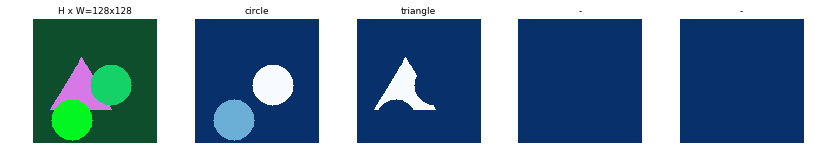

image id: 12 with info:
count 3
mask shape: (128, 128, 3)
/tshape_i: 0
mask shape: (128, 128, 1)
/tshape_i: 1
mask shape: (128, 128, 1)
/tshape_i: 2
mask shape: (128, 128, 1)
shape mask[:, :, -1] :  (128, 128)
occlusion shape: (128, 128)


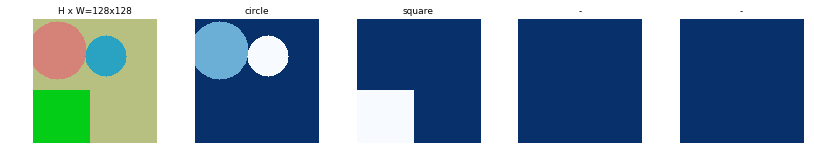

image id: 13 with info:
count 2
mask shape: (128, 128, 2)
/tshape_i: 0
mask shape: (128, 128, 1)
/tshape_i: 1
mask shape: (128, 128, 1)
shape mask[:, :, -1] :  (128, 128)
occlusion shape: (128, 128)


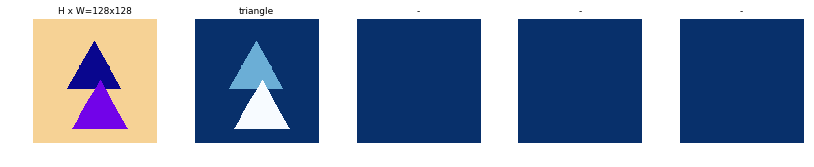

image id: 14 with info:
count 1
mask shape: (128, 128, 1)
/tshape_i: 0
mask shape: (128, 128, 1)
shape mask[:, :, -1] :  (128, 128)
occlusion shape: (128, 128)


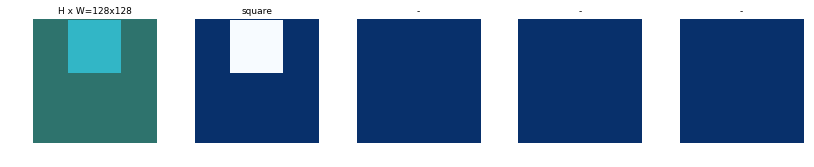

image id: 4 with info:
count 1
mask shape: (128, 128, 1)
/tshape_i: 0
mask shape: (128, 128, 1)
shape mask[:, :, -1] :  (128, 128)
occlusion shape: (128, 128)


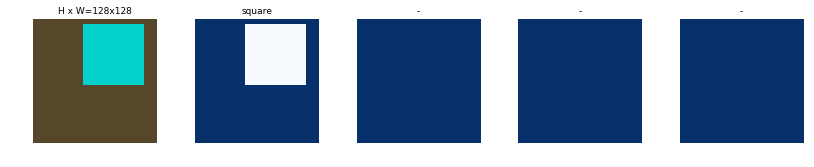

In [151]:
for image_id in image_ids:
    image = dummy_dataset.load_image(image_id)
    mask, class_ids = dummy_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dummy_dataset.class_names)

In [153]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

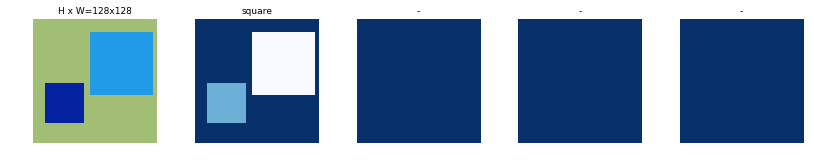

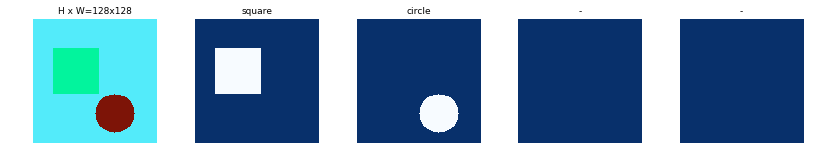

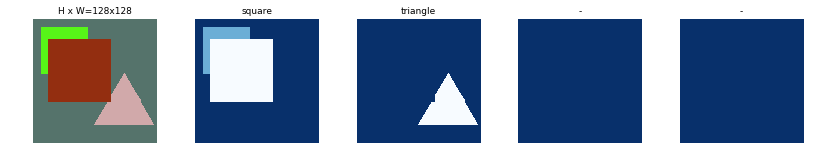

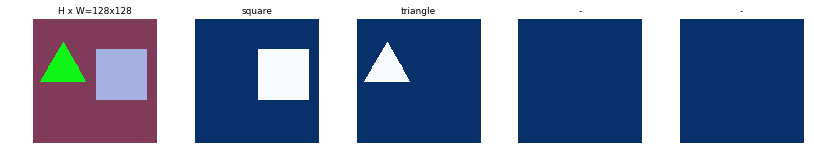

In [154]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Ceate Model

In [155]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [156]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [157]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/supannee/source/deeplearning_projects/Mask_RCNN/logs/shapes20180405T1427/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4   

/home/supannee/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/supannee/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 76s 764ms/step - loss: 1.7600 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.6099 - mrcnn_class_loss: 0.3122 - mrcnn_bbox_loss: 0.3933 - mrcnn_mask_loss: 0.4144 - val_loss: 0.8673 - val_rpn_class_loss: 0.0097 - val_rpn_bbox_loss: 0.4771 - val_mrcnn_class_loss: 0.1235 - val_mrcnn_bbox_loss: 0.1497 - val_mrcnn_mask_loss: 0.1073


In [158]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /home/supannee/source/deeplearning_projects/Mask_RCNN/logs/shapes20180405T1427/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_bra

/home/supannee/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/supannee/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 2/2
100/100 [==============================] - 107s 1s/step - loss: 0.9877 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.4212 - mrcnn_class_loss: 0.1455 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2618 - val_loss: 0.8594 - val_rpn_class_loss: 0.0151 - val_rpn_bbox_loss: 0.3808 - val_mrcnn_class_loss: 0.1537 - val_mrcnn_bbox_loss: 0.0985 - val_mrcnn_mask_loss: 0.2114


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [159]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/supannee/source/deeplearning_projects/Mask_RCNN/logs/shapes20180405T1427/mask_rcnn_shapes_0002.h5


original_image           shape: (128, 128, 3)         min:   24.00000  max:  195.00000
image_meta               shape: (12,)                 min:    0.00000  max:  128.00000
gt_class_id              shape: (2,)                  min:    2.00000  max:    3.00000
gt_bbox                  shape: (2, 4)                min:    0.00000  max:   78.00000
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000


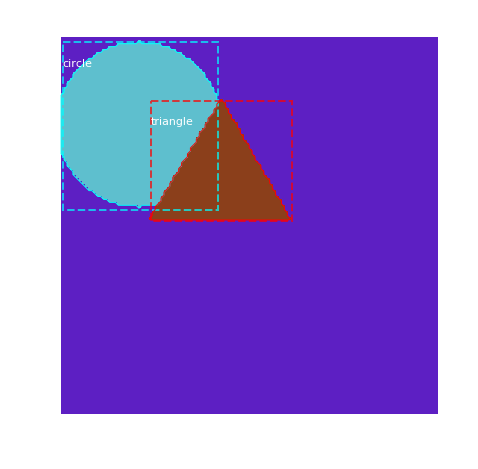

In [167]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   24.00000  max:  195.00000
molded_images            shape: (1, 128, 128, 3)      min:  -99.70000  max:   91.10000
image_metas              shape: (1, 12)               min:    0.00000  max:  128.00000


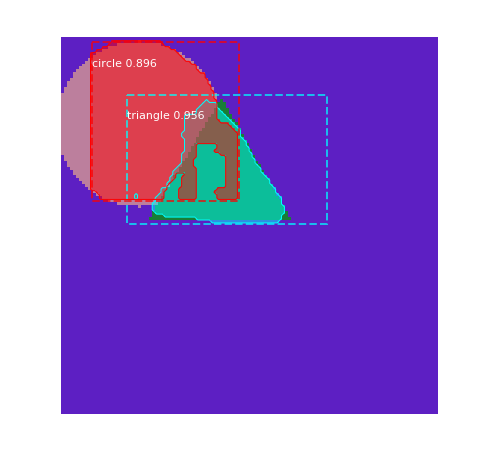

In [168]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [169]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8833333373069763
